In [1]:
import functools
import geopy
import itertools
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj
import requests
import scipy as sp
import rtree
import seaborn as sb
from scipy import signal
# import shapely
import shapely.geometry
%pylab inline

import data_munging

Populating the interactive namespace from numpy and matplotlib


/home/zblan/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


These analyses make my case for using mean of absolute magnitude of force and dividing it by speed. Should be a little more thorough, including testing out standard deviation instead.

In [2]:
rides, readings = data_munging.read_raw_data()
readings = data_munging.clean_readings(readings)
readings = data_munging.add_proj_to_readings(readings, data_munging.NAD83)

In [3]:
n, p = readings.shape

In [4]:
readings_idx = data_munging.insert_readings_rtree(readings)

This is currently randomly sampling points, making a small bounding box, and checking for intersecting. Then, we compare all segments by looking at the ratio of the distance between their endpoints (assign to smaller) and then compare that to their total lengths. Overlapping probably occurs due to snapping readings to streets by iPhone software.

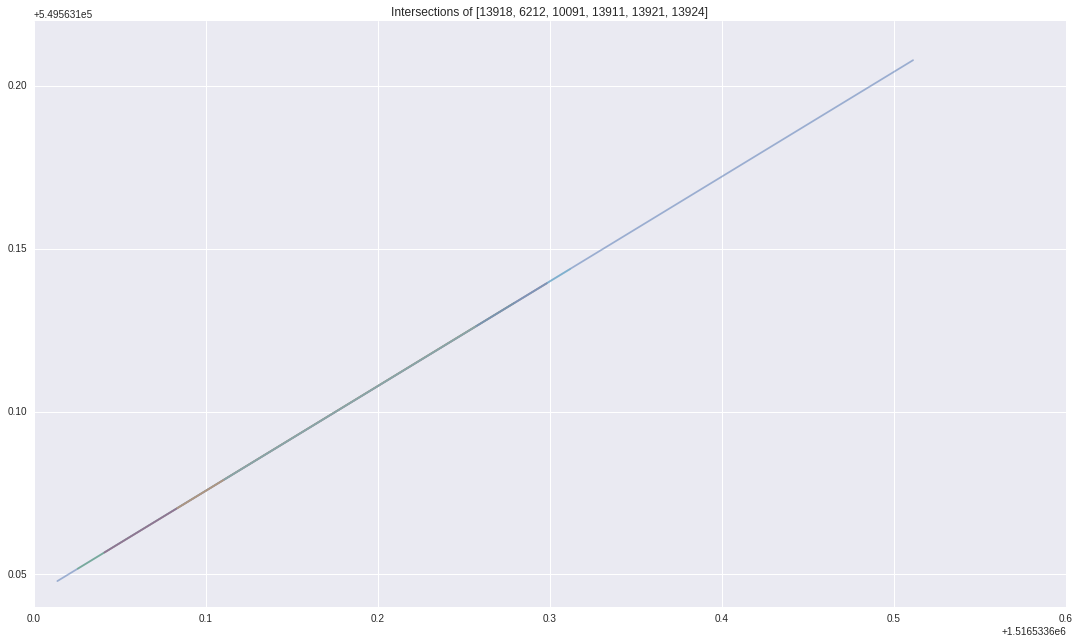

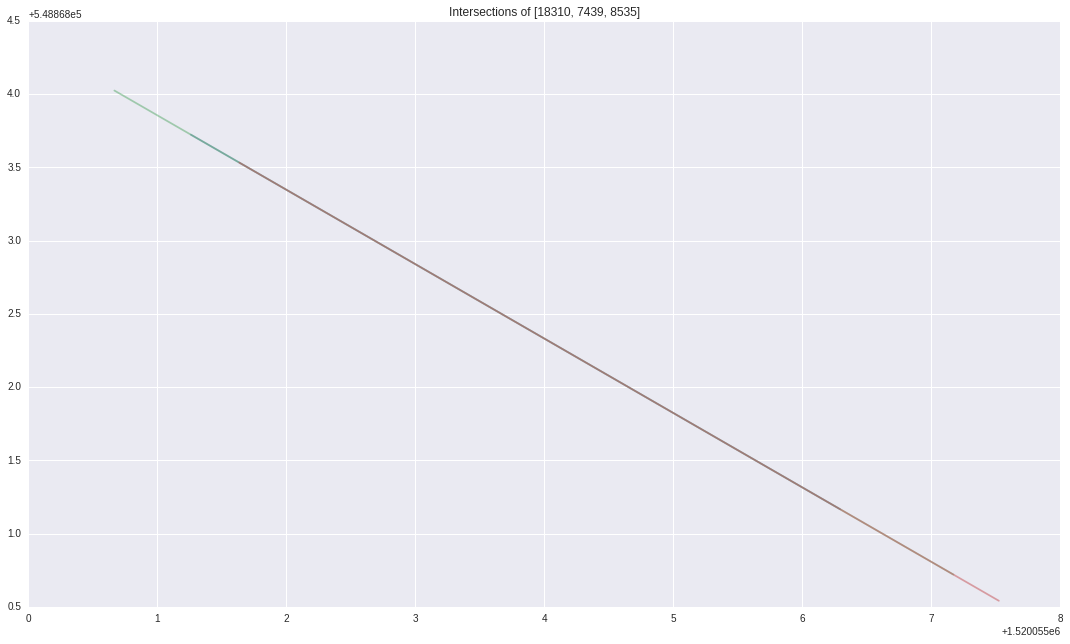

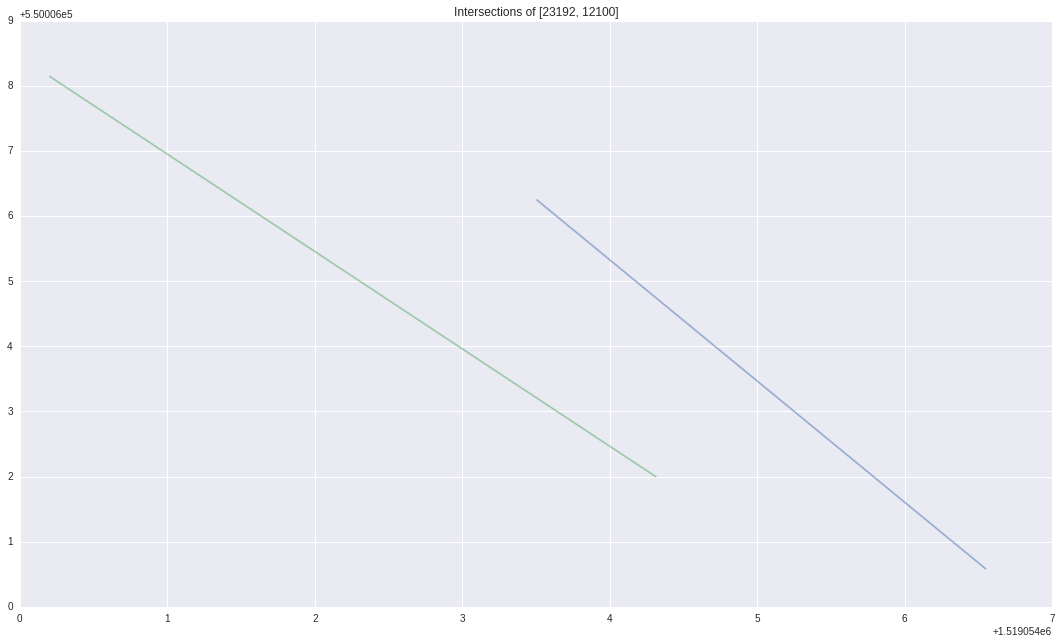

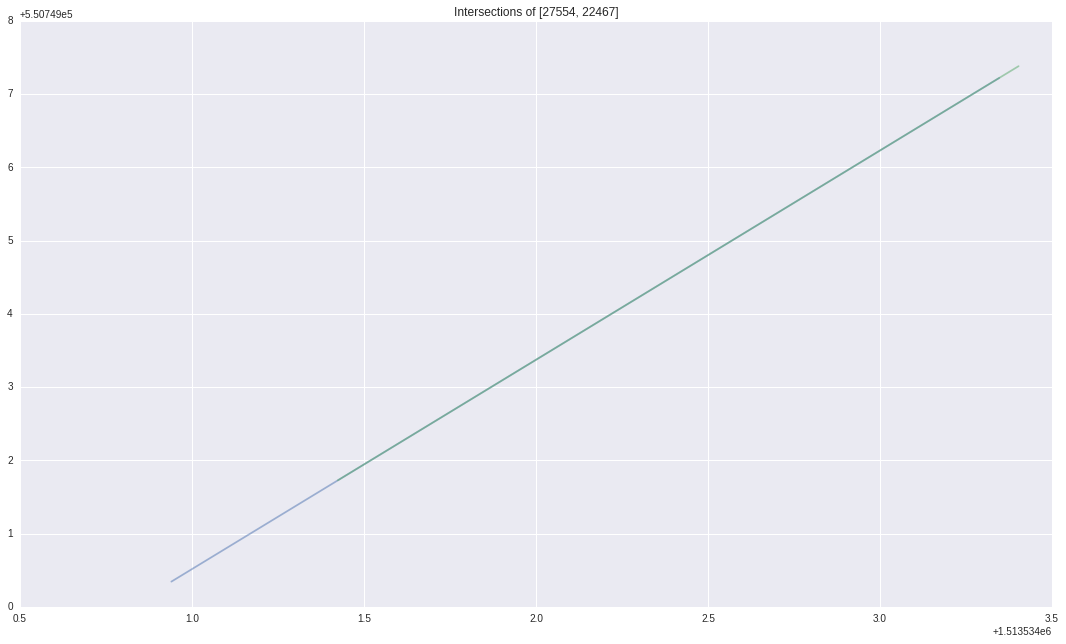

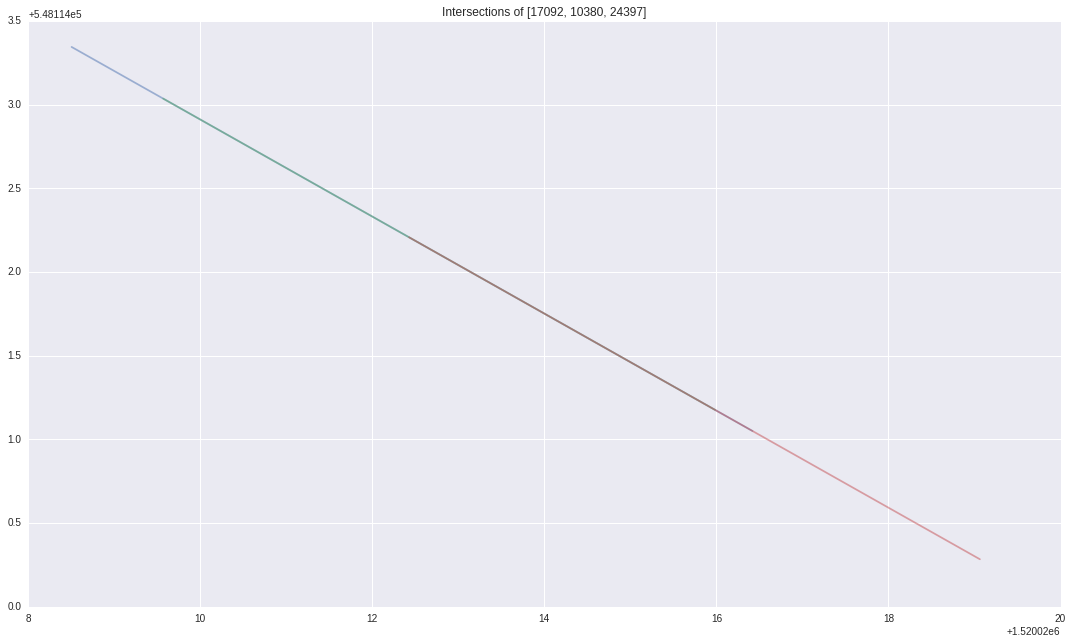

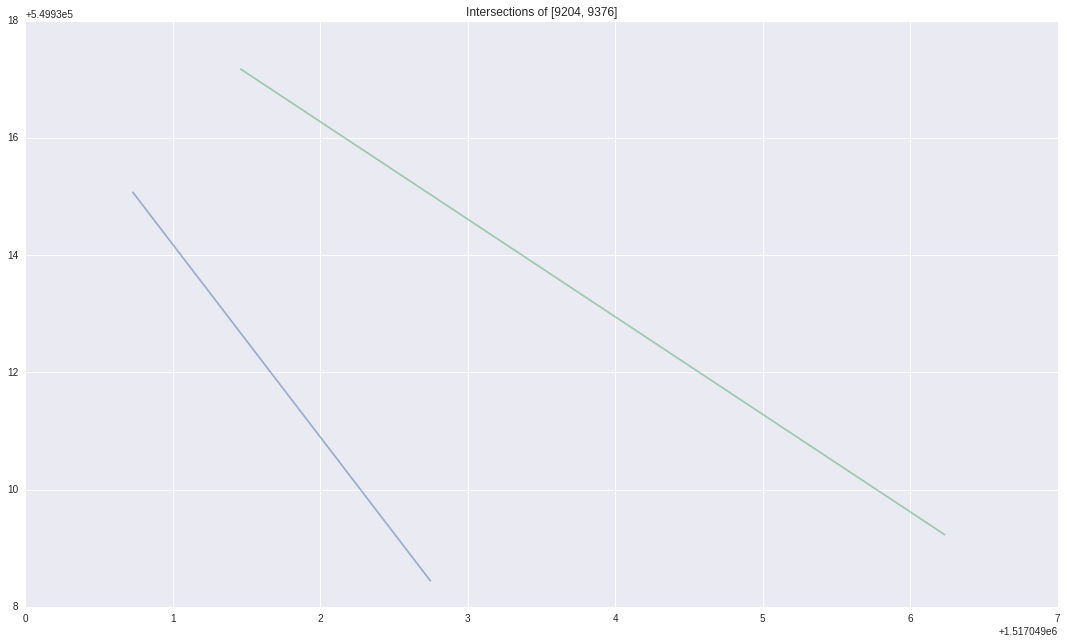

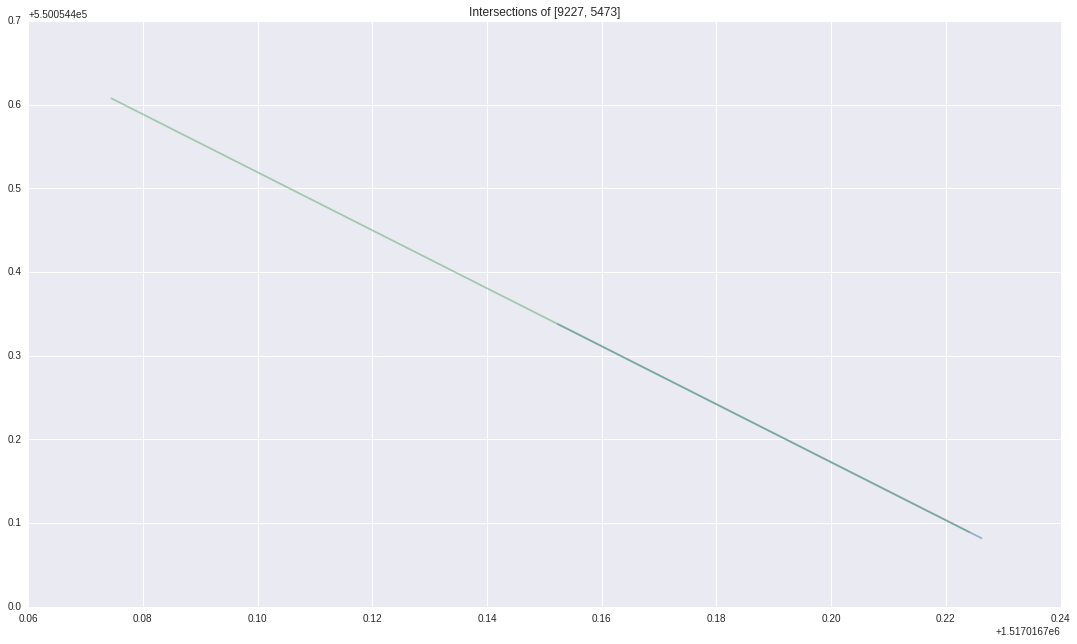

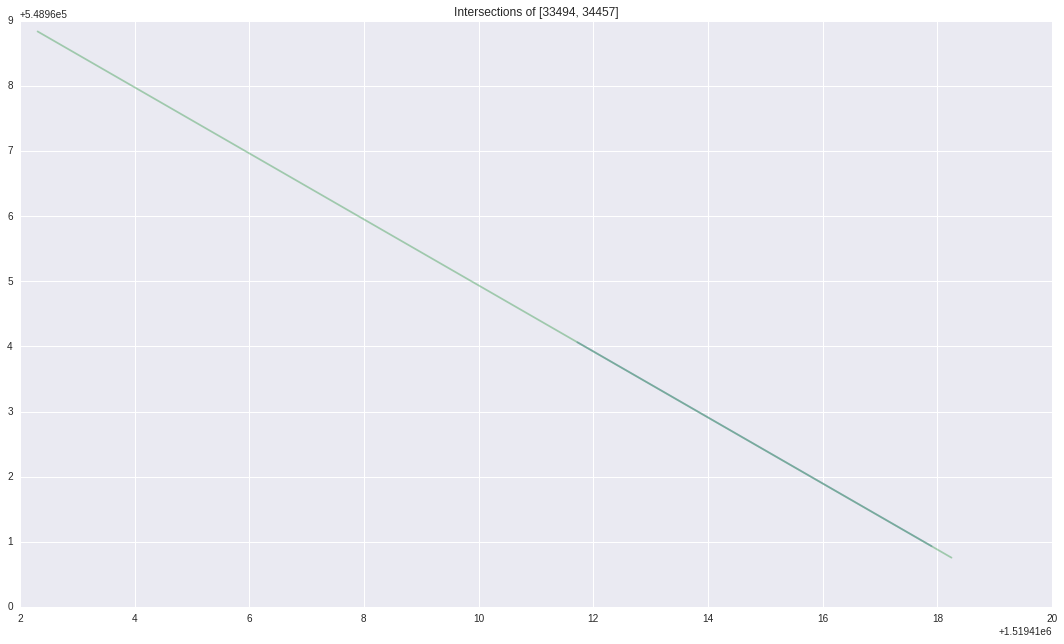

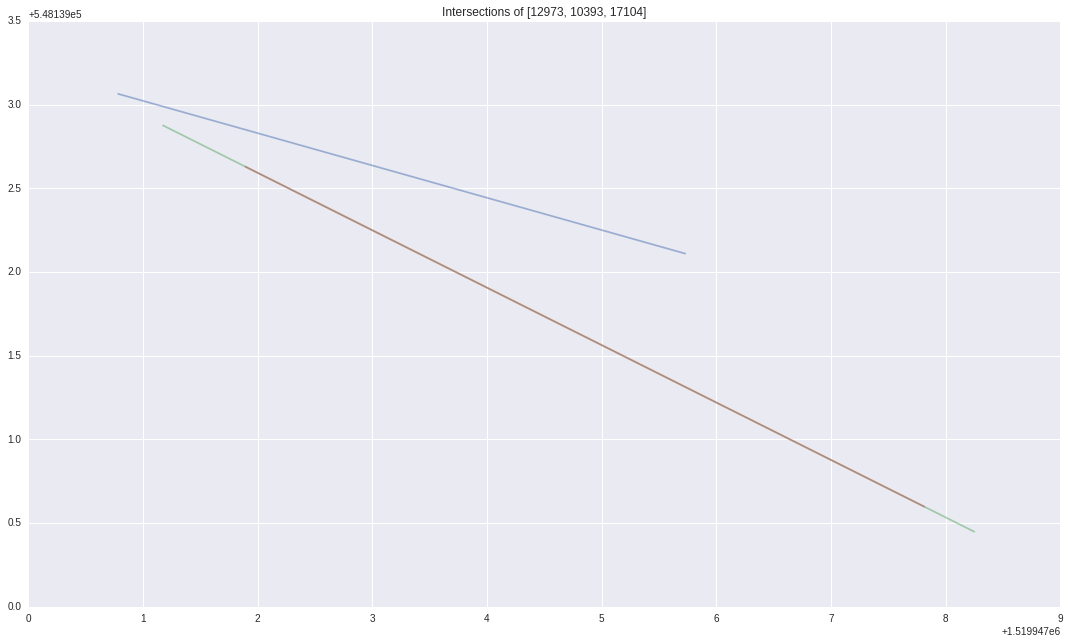

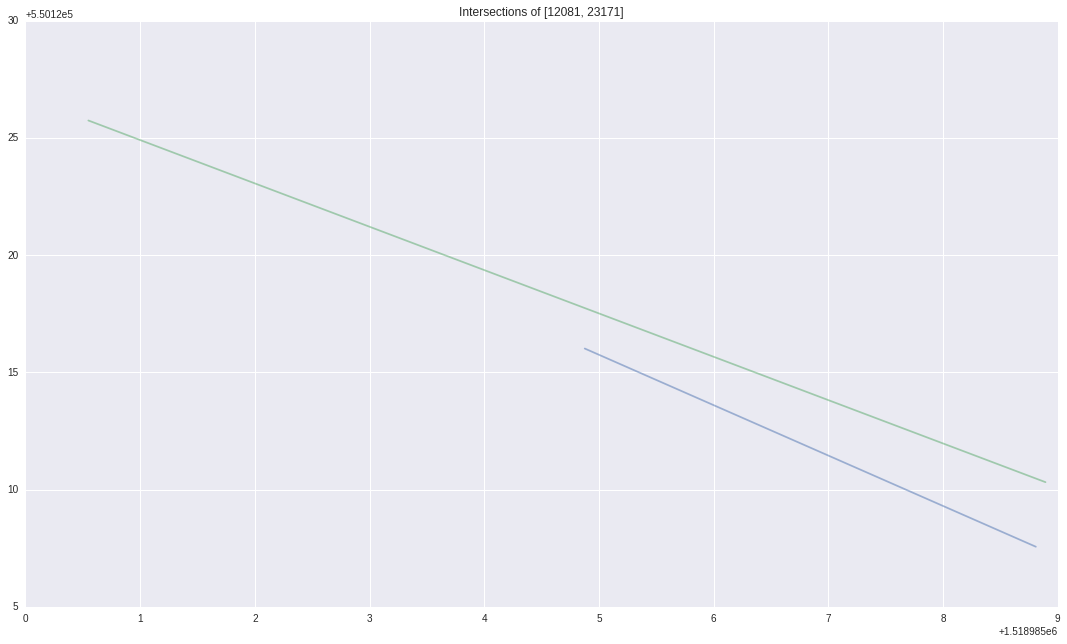

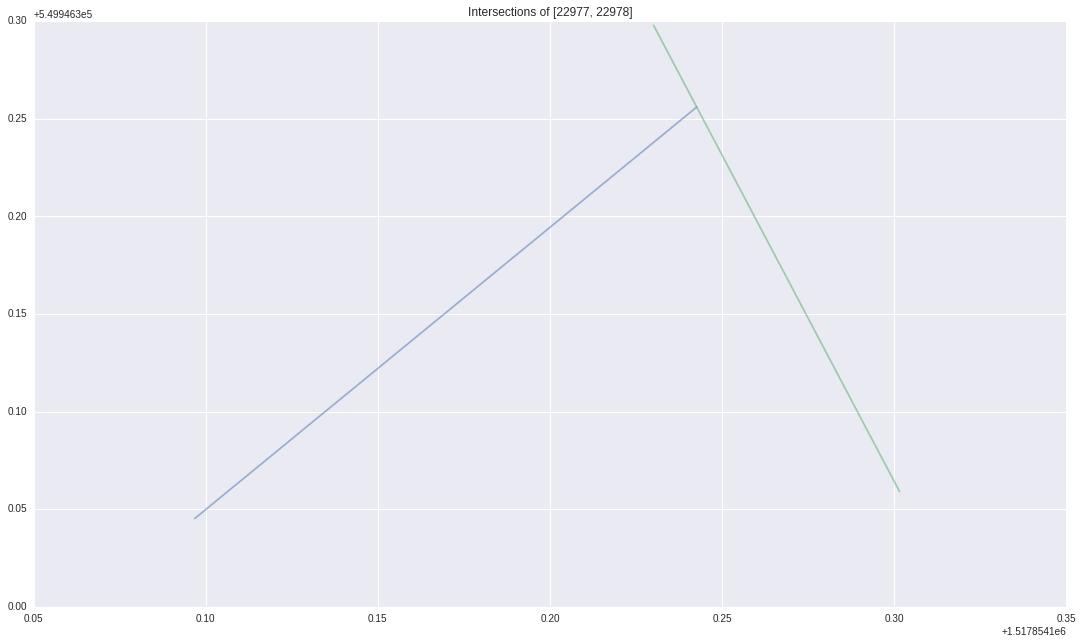

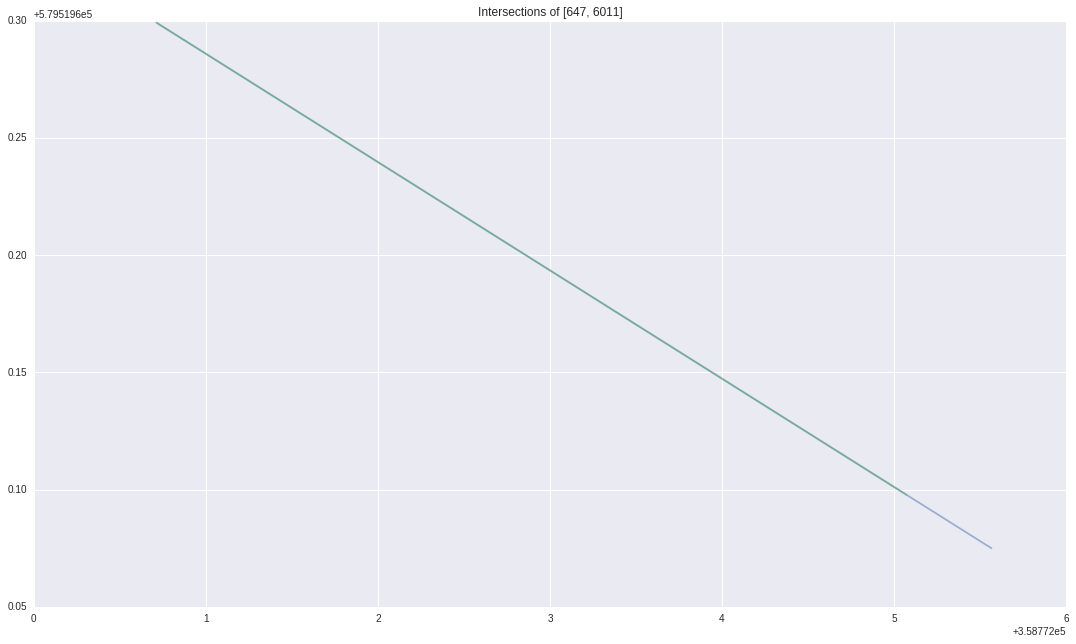

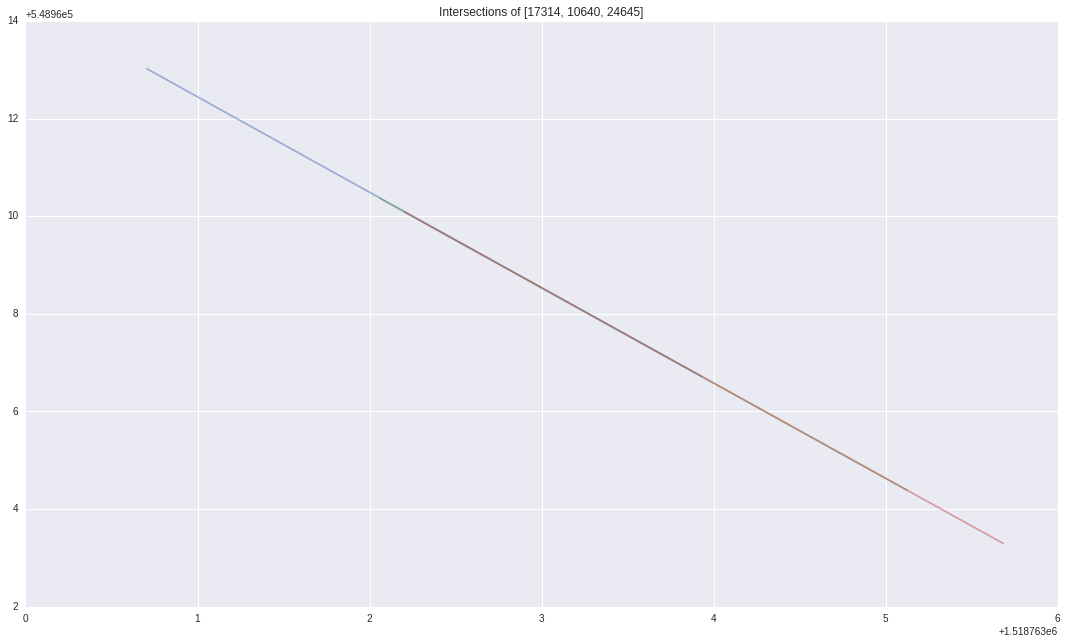

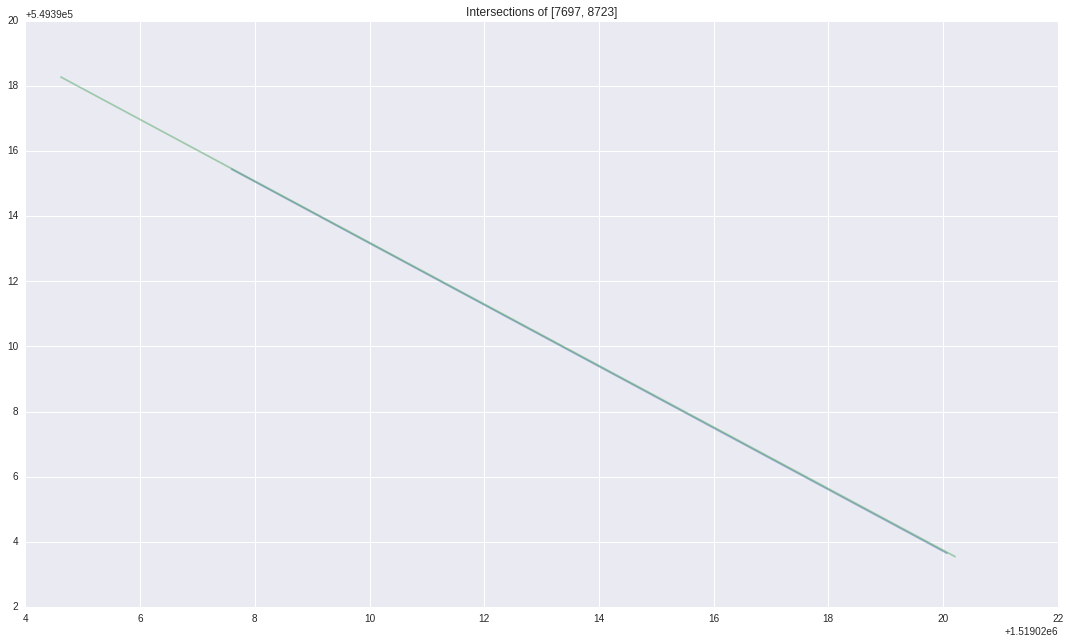

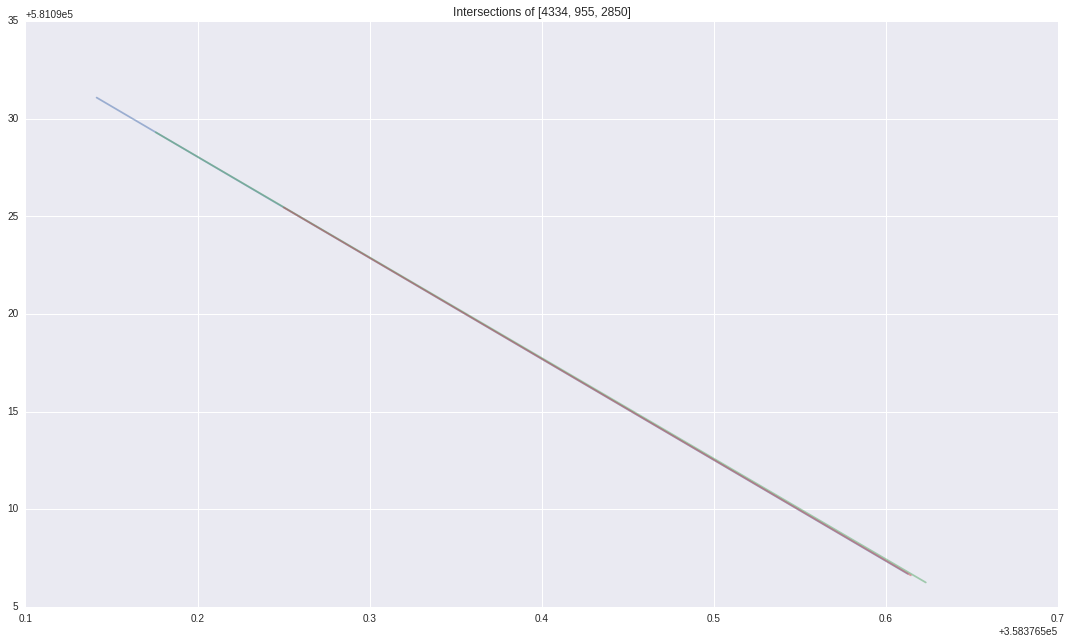

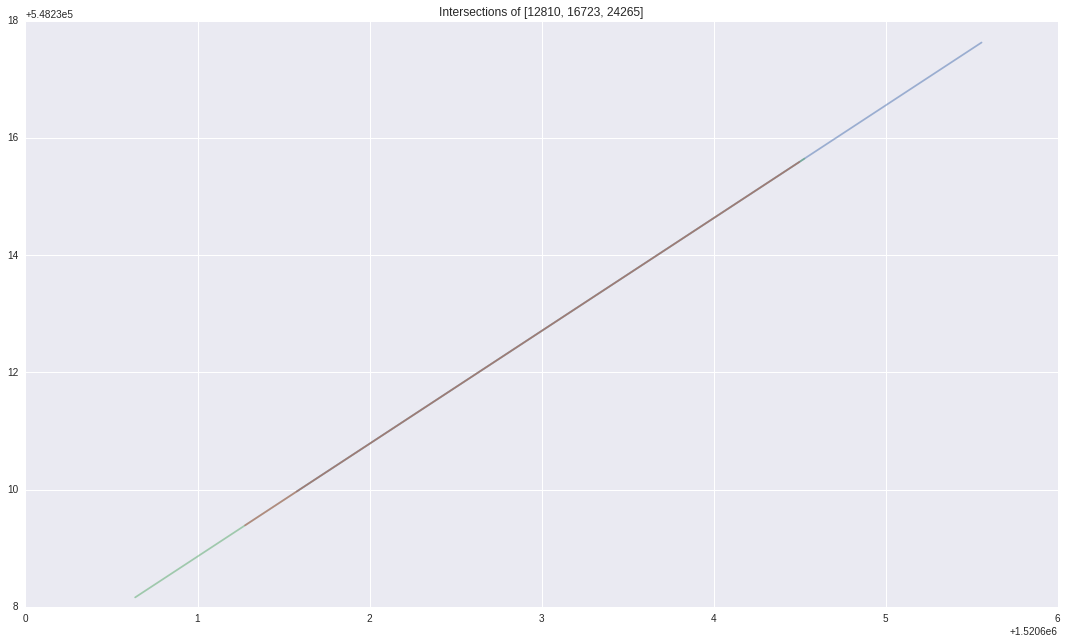

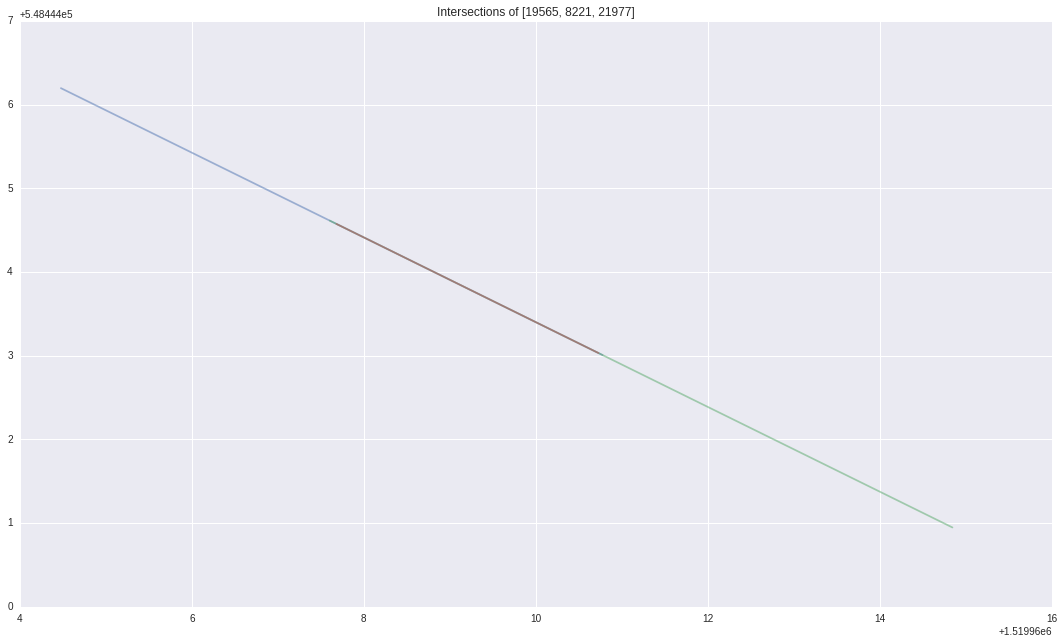

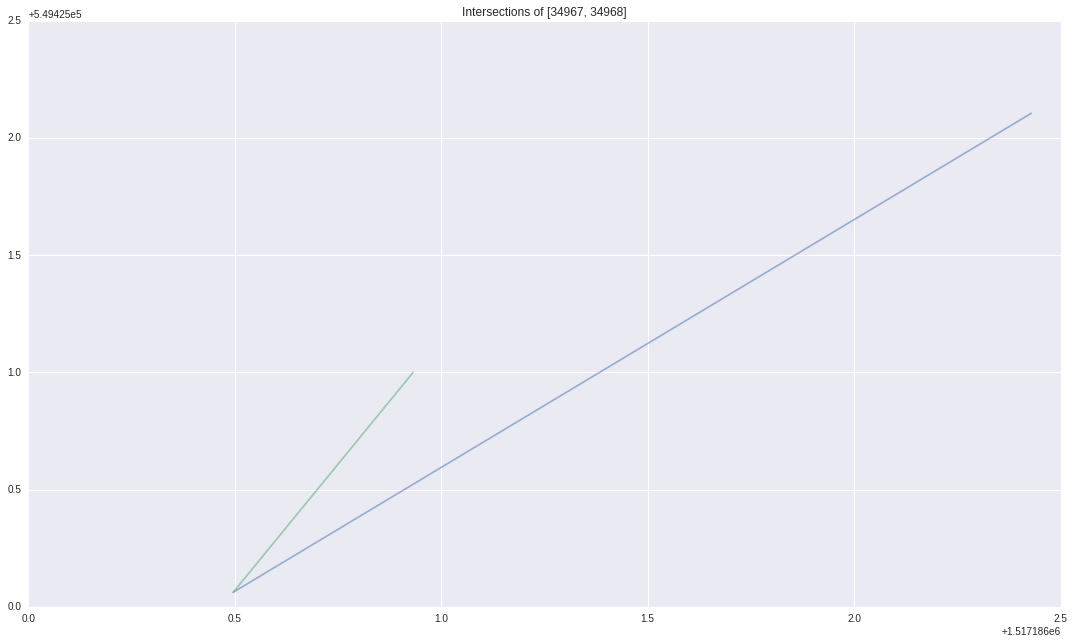

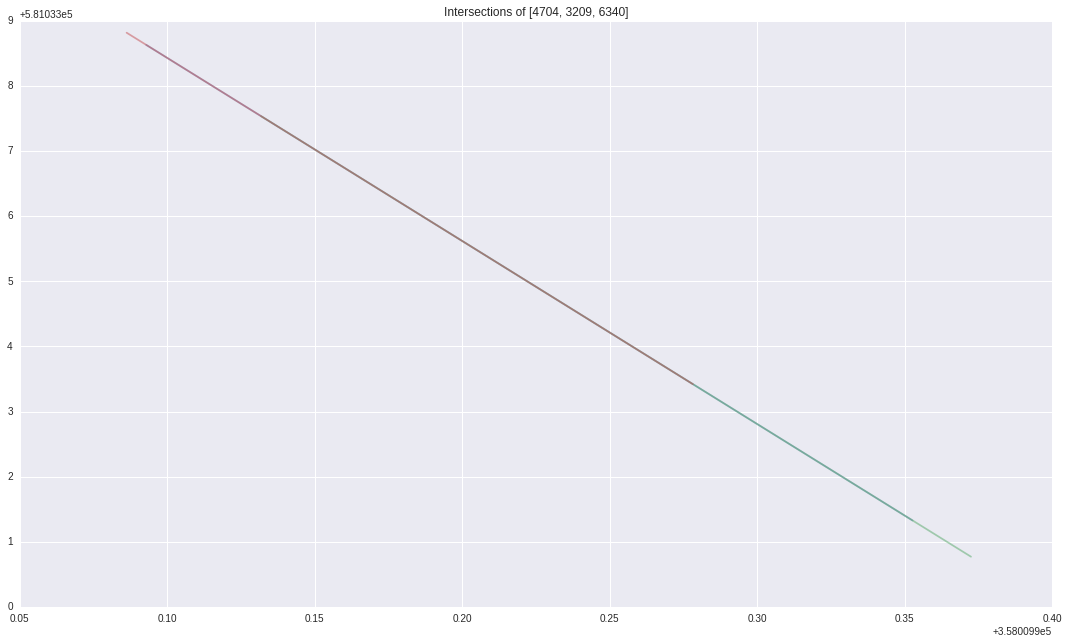

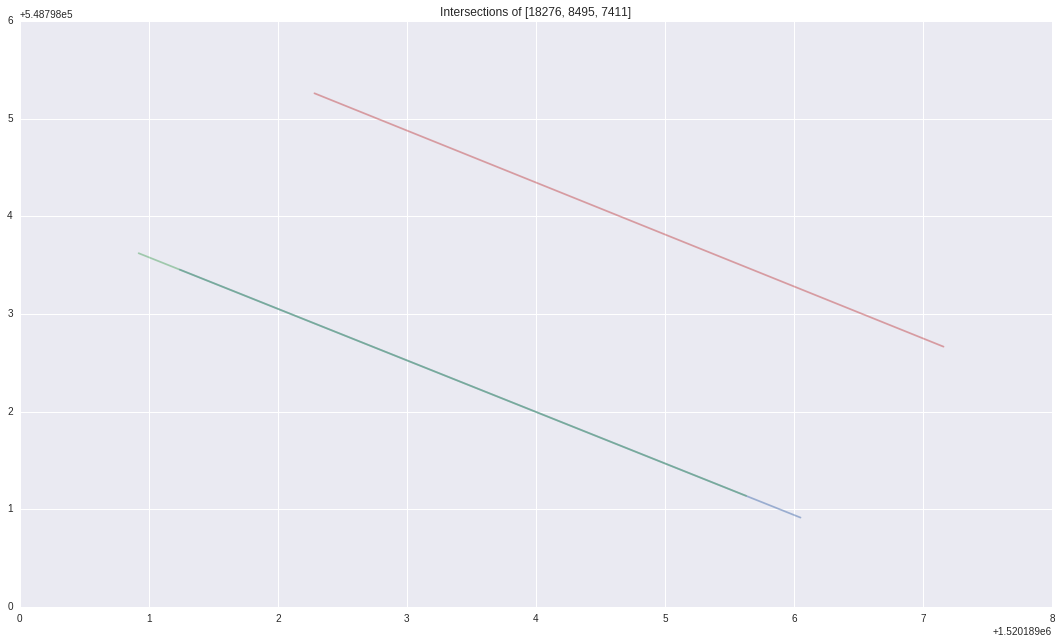

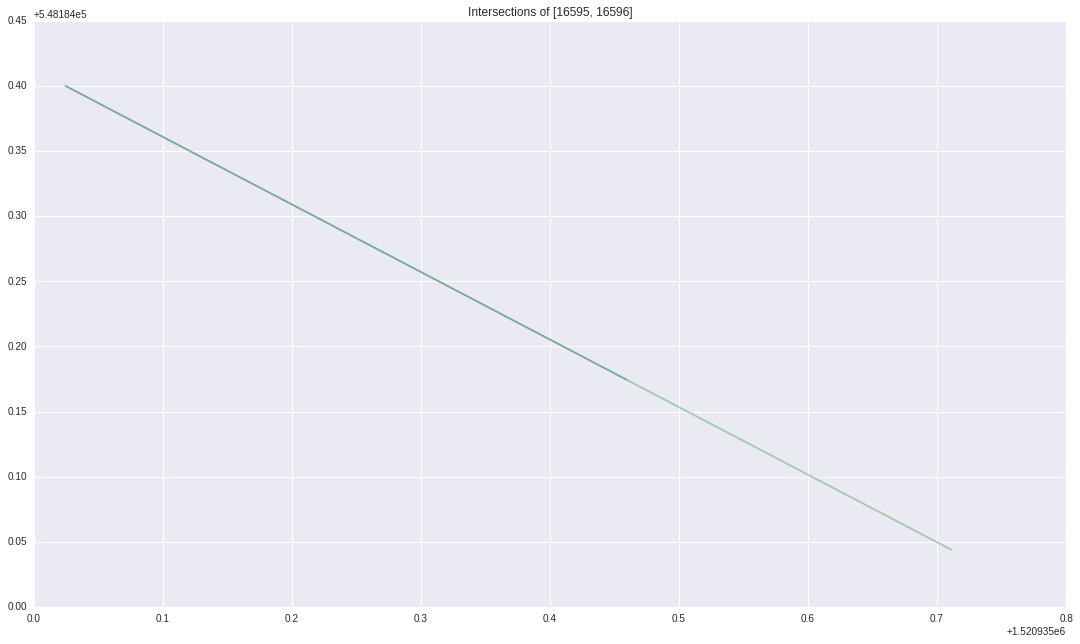

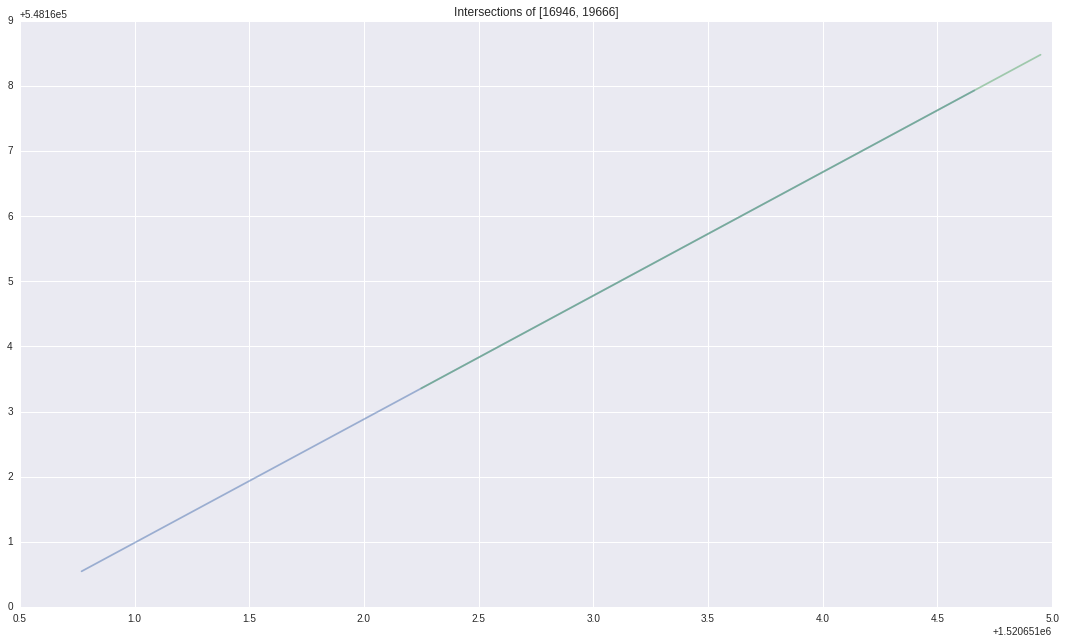

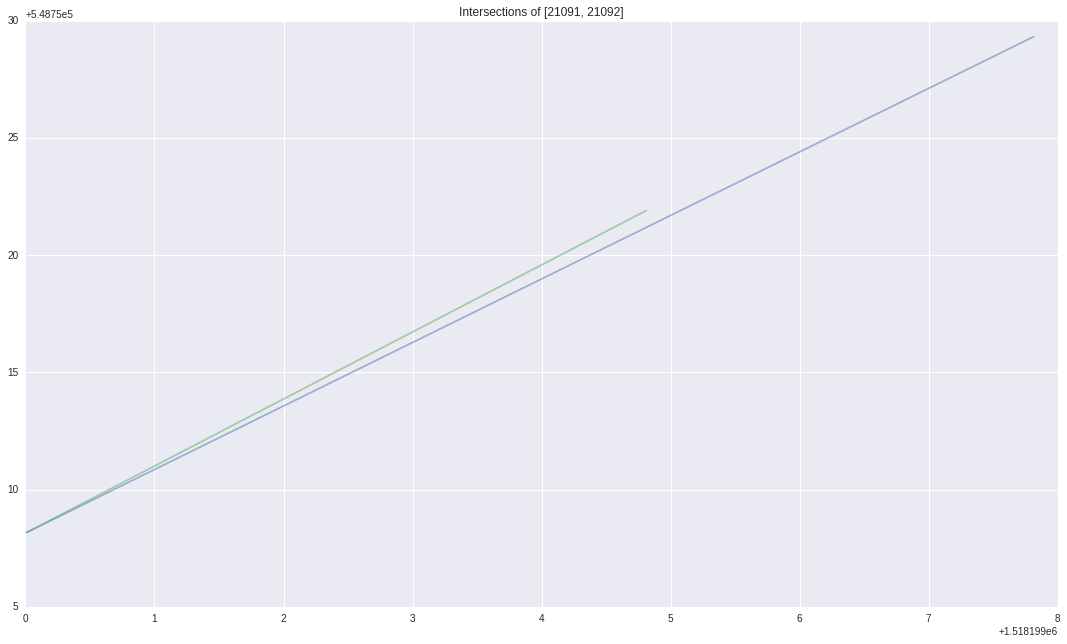

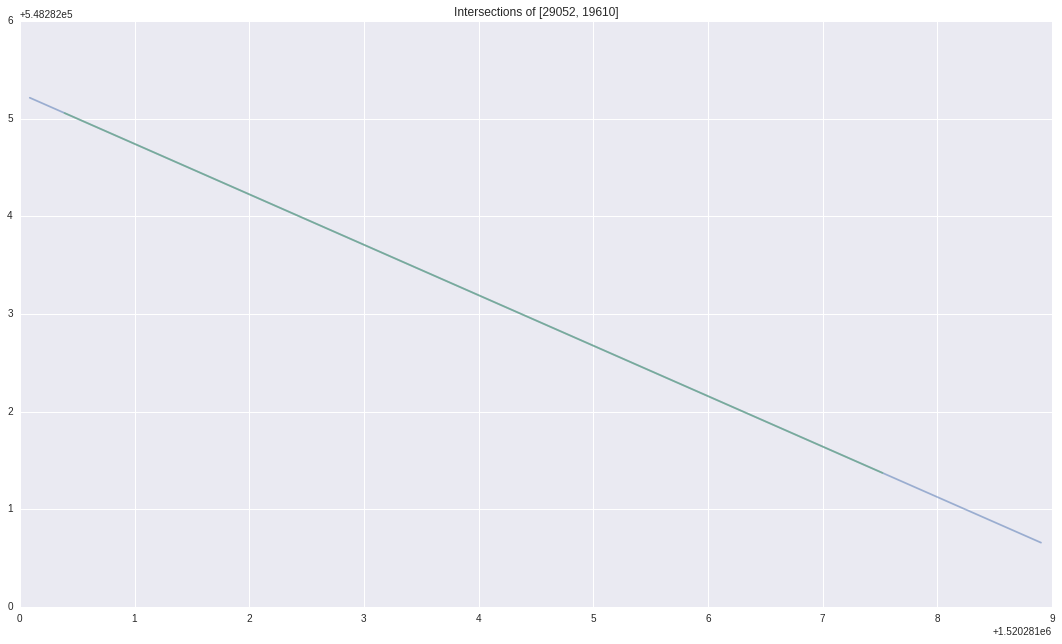

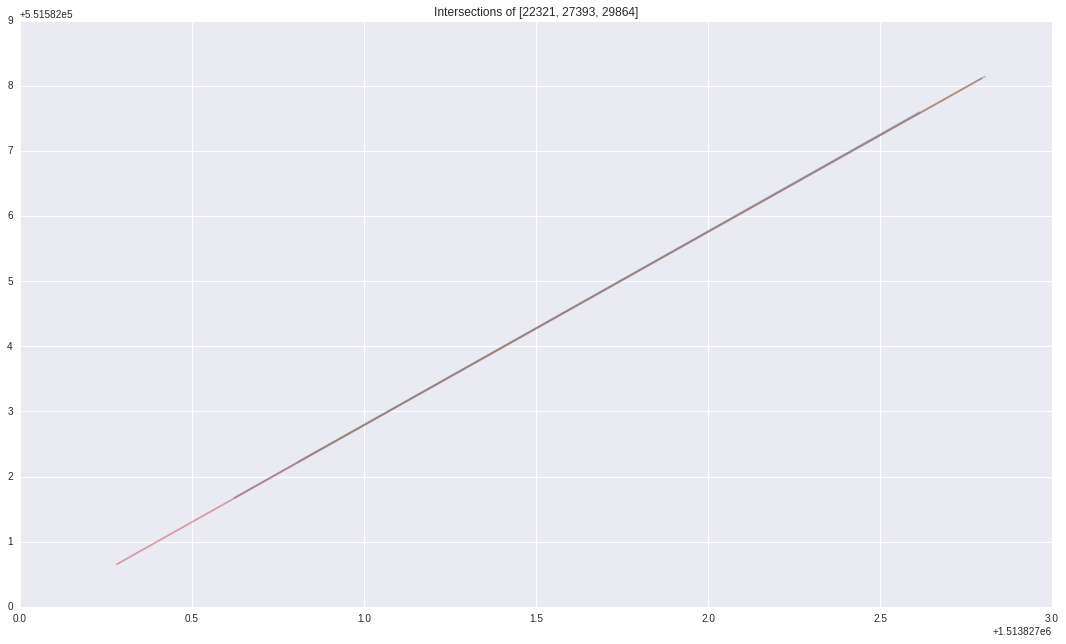

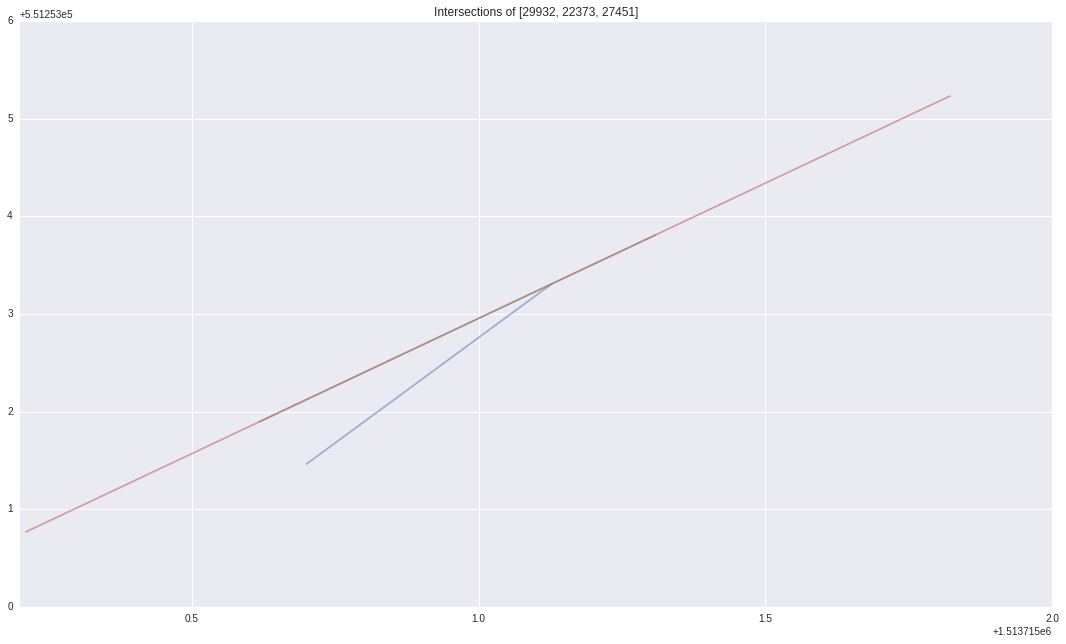

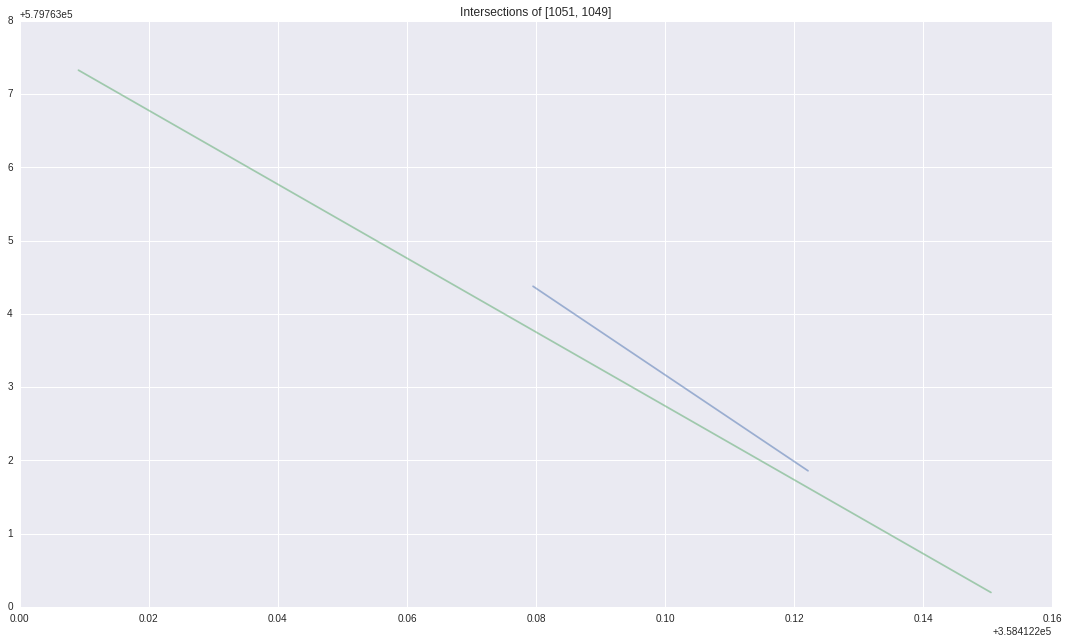

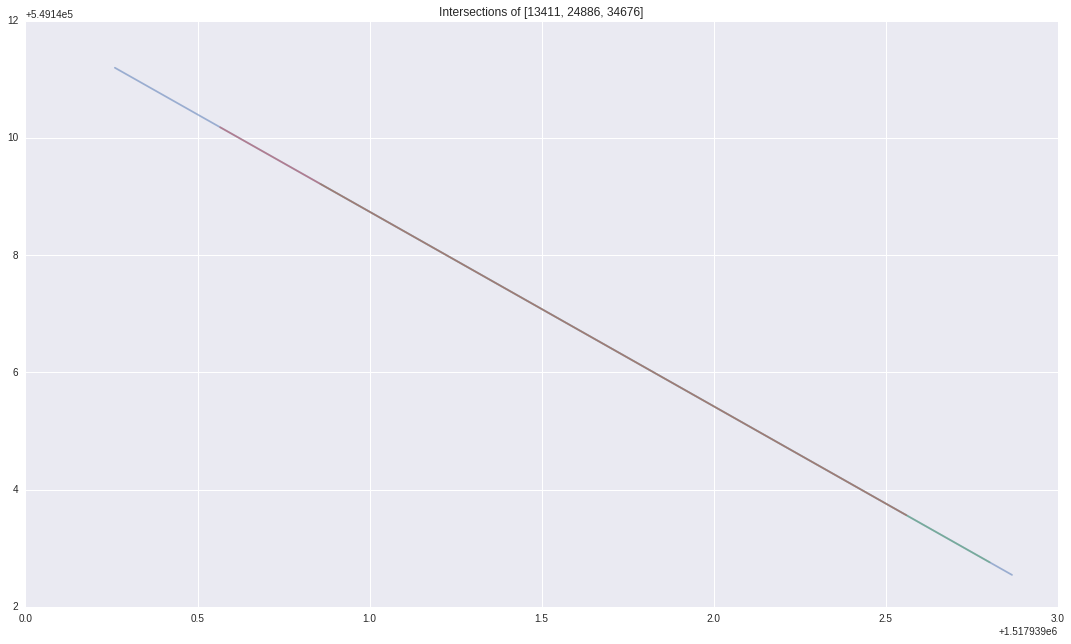

In [5]:
total_intersections = []
for sample_in in range(100):
    random_idx, random_point = data_munging.select_random_point(readings)
    random_bb = data_munging.point_to_bb(*random_point, side_length=0.2)
    intersecting_segments = list(readings_idx.intersection(random_bb))
    intersecting_segments = [i for i in intersecting_segments if data_munging.calc_reading_diffs(readings.ix[i, :], readings.ix[random_idx, :]) < 0.5]
    if len(intersecting_segments) > 1:
        for i in intersecting_segments:
            plt.plot([readings.ix[i, 'start_x'], readings.ix[i, 'end_x']],
                     [readings.ix[i, 'start_y'], readings.ix[i, 'end_y']],
                    alpha=0.5)
        fig = plt.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.title('Intersections of ' + str(intersecting_segments))
        plt.show()

In [6]:
total_data_points = 0
total_tries = 0
examined_ids = set()
ids0 = list()
ids1 = list()
while total_data_points < 5000 and total_tries < 100000:
    total_tries += 1
    random_idx, random_point = data_munging.select_random_point(readings)
    random_bb = data_munging.point_to_bb(*random_point, side_length=0.2)
    intersecting_segments = list(readings_idx.intersection(random_bb))
    intersecting_segments = set([i for i in intersecting_segments if data_munging.calc_reading_diffs(readings.ix[i, :], readings.ix[random_idx, :]) < 0.4])
    intersecting_segments.difference_update(examined_ids)
    examined_ids.update(intersecting_segments)
    if intersecting_segments > 1:
        for idx_pair in itertools.combinations(intersecting_segments, 2):
            ids0.append(idx_pair[0])
            ids1.append(idx_pair[1])
            total_data_points += 1

In [7]:
pairwise_comps = pd.DataFrame({'id0': ids0, 'id1': ids1})

In [8]:
print len(readings.index)
print len(set(readings.index))

35884
35884


In [9]:
print len(pairwise_comps.index)
print len(set(pairwise_comps.index))

5005
5005


In [10]:
for i in ('0', '1'):
    for var in ('std_z', 'gps_speed', 'abs_mean_total'):
        pairwise_comps[var + i] = readings[var][pairwise_comps['id' + i]].values
for i in ('0', '1'):
    pairwise_comps['abs_mean_over_speed' + i] = pairwise_comps['abs_mean_total' + i] /  pairwise_comps['gps_speed' + i]

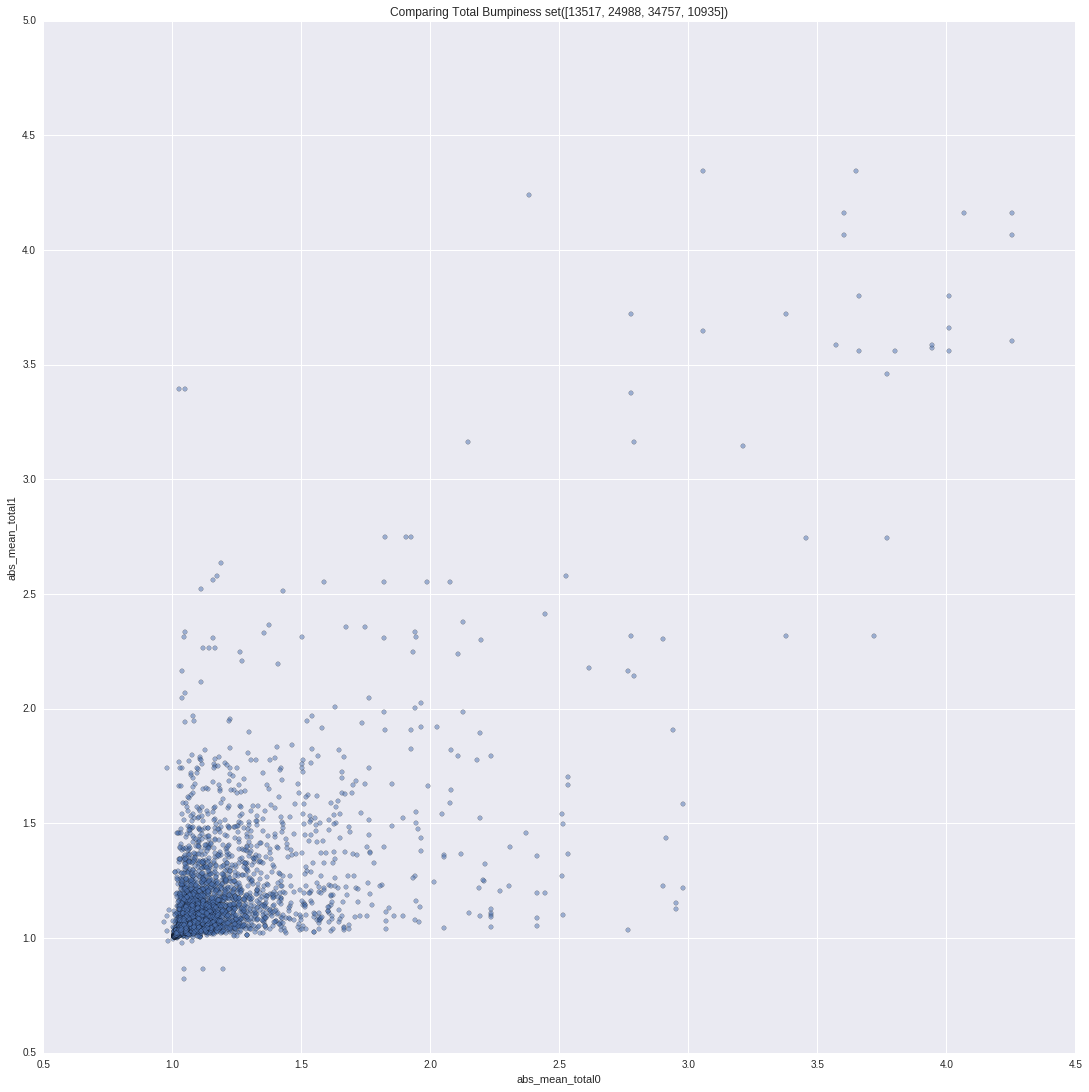

In [12]:
pairwise_comps.plot(x='abs_mean_total0', y='abs_mean_total1', kind='scatter', alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plt.title('Comparing Total Bumpiness ' + str(intersecting_segments))
plt.show()

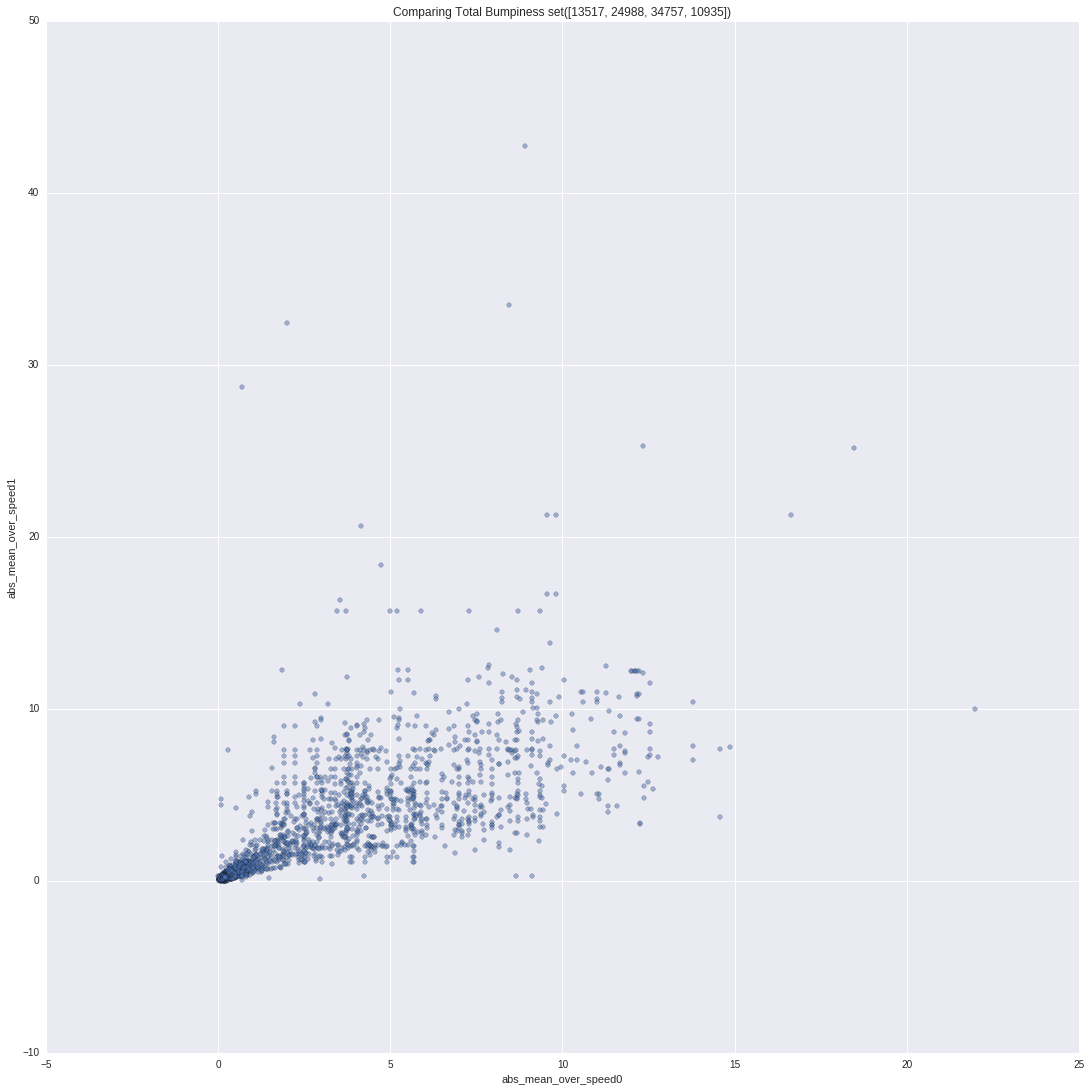

In [19]:
pairwise_comps.plot(x='abs_mean_over_speed0', y='abs_mean_over_speed1', kind='scatter', alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plt.title('Comparing Total Bumpiness ' + str(intersecting_segments))
plt.show()

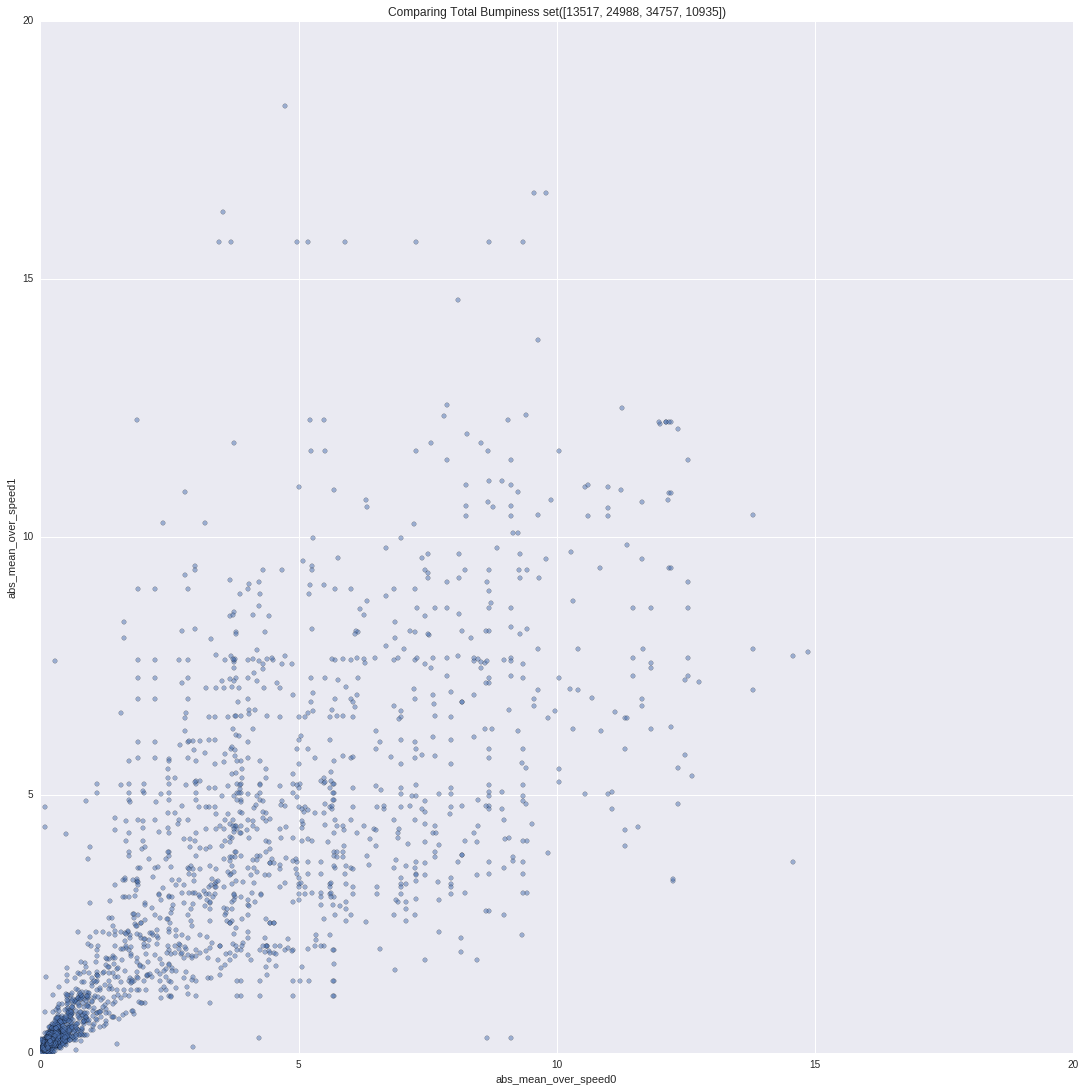

In [18]:
pairwise_comps.plot(x='abs_mean_over_speed0', y='abs_mean_over_speed1', kind='scatter', alpha=0.5)
fig = plt.gcf()
fig.set_size_inches(18.5, 18.5)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.title('Comparing Total Bumpiness ' + str(intersecting_segments))
plt.show()

In [13]:
np.corrcoef(pairwise_comps['abs_mean_total0'], pairwise_comps['abs_mean_total1'])

array([[ 1.        ,  0.71298988],
       [ 0.71298988,  1.        ]])

In [17]:
np.corrcoef(pairwise_comps['abs_mean_over_speed0'], pairwise_comps['abs_mean_over_speed1'])

array([[ 1.        ,  0.79849815],
       [ 0.79849815,  1.        ]])

We can probably increase this correlation by throwing out very low speeds, really short readings, etc. Which is to say, outliers.